<a href="https://colab.research.google.com/github/jwkanggist/EverybodyTensorflow2.0/blob/master/lab3_curvefitting_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB3 Curve-fitting
목적: 가장 기본적인 머신러닝 연습문제인 curve fitting 문제를 tf2.0을 가지고 풀어보자!

In [4]:
# preprocessor parts

from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np

from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt

from datetime import datetime

TensorFlow 2.x selected.


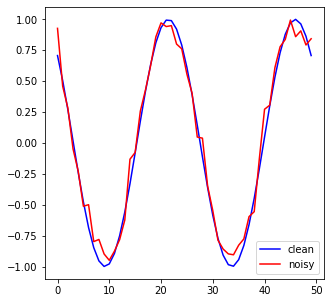

In [6]:
# Data pipeline: generation of data set

total_size = 5000
training_size = 4000
validation_size = total_size - training_size

xsize = 50 # the size of single x_data

x_data = np.zeros([xsize, total_size])
cos_x  = np.zeros([xsize, total_size])

mag     = 1.0
phase_rad = np.pi/4
rad_freq = np.pi / 2.0

for i in range(total_size):
    x_data[:,i] =  np.linspace(-4,4,xsize)
cos_x =  np.cos(rad_freq*x_data + phase_rad)



noise_var   = 0.01
noise       = np.sqrt(noise_var) * np.random.randn(xsize,total_size)
y_clean     = cos_x
y_data      = y_clean + noise

x_train = x_data[:,0:training_size].transpose()
y_train = y_data[:,0:training_size].transpose()

x_test = x_data[:,training_size:-1].transpose()
y_test = y_data[:,training_size:-1].transpose()

# signal plot
hfig1= plt.figure(1,figsize=[5,5])
plt.plot(cos_x[:,1],color='b',label='clean')
plt.plot(y_data[:,1],color='r',label='noisy')
plt.legend()

In [0]:
# model building

net_in = tf.keras.layers.Input(shape=(xsize,))
net = tf.keras.layers.Dense(xsize, activation='linear')(net_in)
net = tf.cos(net)
net = tf.keras.layers.Dense(xsize, activation='linear')(net)

model = tf.keras.models.Model(inputs=net_in,outputs=net)

model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

In [22]:
# model training and evaluation part
training_epochs = 20
model.fit(x_train, y_train, epochs=training_epochs,batch_size=128)
model.evaluate(x_test,  y_test, verbose=2)

Train on 4000 samples
Epoch 1/20
4000/4000 [==============================] - 0s 95us/sample - loss: 0.1761 - accuracy: 0.1105
Epoch 2/20
4000/4000 [==============================] - 0s 19us/sample - loss: 0.0120 - accuracy: 0.1828
Epoch 3/20
4000/4000 [==============================] - 0s 19us/sample - loss: 0.0101 - accuracy: 0.1922
Epoch 4/20
4000/4000 [==============================] - 0s 19us/sample - loss: 0.0100 - accuracy: 0.2033
Epoch 5/20
4000/4000 [==============================] - 0s 20us/sample - loss: 0.0100 - accuracy: 0.2033
Epoch 6/20
4000/4000 [==============================] - 0s 20us/sample - loss: 0.0100 - accuracy: 0.2035
Epoch 7/20
4000/4000 [==============================] - 0s 19us/sample - loss: 0.0100 - accuracy: 0.2020
Epoch 8/20
4000/4000 [==============================] - 0s 23us/sample - loss: 0.0100 - accuracy: 0.2055
Epoch 9/20
4000/4000 [==============================] - 0s 20us/sample - loss: 0.0101 - accuracy: 0.2045
Epoch 10/20
4000/4000 [==========

[0.010038316823184132, 0.16516517]

Text(0, 0.5, 'Y data')

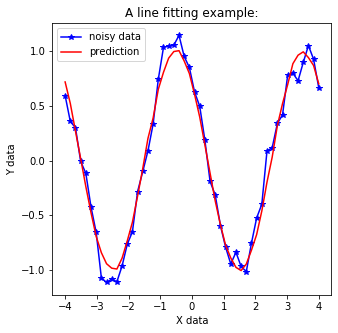

In [25]:
# prediction 

plt.figure(1,figsize=(5,5))
test_input = x_test[0,:]
test_output = y_test[0,:]
pred_y = model.predict(test_input.reshape([1,xsize]))
plt.plot(test_input,test_output,label='noisy data',color='b',marker='*')
plt.plot(test_input, pred_y.reshape([xsize,]),label='prediction',color='r')
plt.legend()
plt.title('A line fitting example:')
plt.xlabel('X data')
plt.ylabel('Y data')